## Flood Prediction in Malawi:
On 14 March 2019, tropical Cyclone Idai made landfall at the port of Beira, Mozambique, before moving across the region. Millions of people in Malawi, Mozambique and Zimbabwe have been affected by what is the worst natural disaster to hit southern Africa in at least two decades.

In recent decades, countries across Africa have experienced an increase in the frequency and severity of floods. Malawi has been hit with major floods in 2015 and again in 2019. In fact, between 1946 and 2013, floods accounted for 48% of major disasters in Malawi. The Lower Shire Valley in southern Malawi, bordering Mozambique, composed of Chikwawa and Nsanje Districts is the area most prone to flooding.

The objective of this challenge is to build a machine learning model that helps predict the location and extent of floods in southern Malawi.

This competition is sponsored by [Arm](https://www.arm.com/) and [UNICEF](https://www.unicef.org/) as part of the [2030Vision](https://www.2030vision.com/) initiative.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

import utils
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Paths to data
data_path = './raw_data/Train.csv'
submission_path = './raw_data/SampleSubmission.csv'

## Data Cleaning and Analysis

In [3]:
# The datasets
dataset = utils.read_data(data_path)
submission = utils.read_data(submission_path)

In [4]:
dataset.T

,0,1,2,3,4,5,6,7,8,9,...,16456,16457,16458,16459,16460,16461,16462,16463,16464,16465
X,34.26,34.26,34.26,34.26,34.26,34.26,34.26,34.26,34.26,34.27,...,35.86,35.86,35.86,35.86,35.86,35.86,35.86,35.86,35.86,35.86
Y,-15.91,-15.9,-15.89,-15.88,-15.87,-15.86,-15.85,-15.84,-15.83,-15.92,...,-15.49,-15.48,-15.47,-15.46,-15.45,-15.44,-15.43,-15.42,-15.41,-15.4
target_2015,0,0,0,0,0,0,0,0,0,0,...,1,0.966923,0.622703,0.0572244,0,0,0,0,0,0
elevation,887.764,743.404,565.728,443.393,437.443,405.632,389.261,383.123,382.92,826.058,...,624.21,624.426,625.041,627.22,631.86,635.675,632.599,632.45,629.273,626.165
precip 2014-11-16 - 2014-11-23,0,0,0,0,0,0,0,0,0,0,...,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566
precip 2014-11-23 - 2014-11-30,0,0,0,0,0,0,0,0,0,0,...,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555
precip 2014-11-30 - 2014-12-07,0,0,0,0,0,0,0,0,0,0,...,12.882,12.882,12.882,12.882,12.882,12.882,12.882,12.882,12.882,12.882
precip 2014-12-07 - 2014-12-14,14.844,14.844,14.844,14.844,14.844,14.844,14.844,14.844,14.844,14.844,...,8.81014,8.81014,8.81014,8.81014,8.81014,8.81014,8.81014,8.81014,8.81014,8.81014
precip 2014-12-14 - 2014-12-21,14.5528,14.5528,14.5528,14.5528,14.5528,14.5528,14.5528,14.5528,14.5528,14.5528,...,6.17983,6.17983,6.17983,6.17983,6.17983,6.17983,6.17983,6.17983,6.17983,6.17983
precip 2014-12-21 - 2014-12-28,12.2378,12.2378,12.2378,12.2378,12.2378,12.2378,12.2378,12.2378,12.2378,12.2378,...,9.86369,9.86369,9.86369,9.86369,9.86369,9.86369,9.86369,9.86369,9.86369,9.86369


In [5]:
# Train info
utils.analyze_data(dataset)

Null value check:
 X                                 0
Y                                 0
target_2015                       0
elevation                         0
precip 2014-11-16 - 2014-11-23    0
precip 2014-11-23 - 2014-11-30    0
precip 2014-11-30 - 2014-12-07    0
precip 2014-12-07 - 2014-12-14    0
precip 2014-12-14 - 2014-12-21    0
precip 2014-12-21 - 2014-12-28    0
precip 2014-12-28 - 2015-01-04    0
precip 2015-01-04 - 2015-01-11    0
precip 2015-01-11 - 2015-01-18    0
precip 2015-01-18 - 2015-01-25    0
precip 2015-01-25 - 2015-02-01    0
precip 2015-02-01 - 2015-02-08    0
precip 2015-02-08 - 2015-02-15    0
precip 2015-02-15 - 2015-02-22    0
precip 2015-02-22 - 2015-03-01    0
precip 2015-03-01 - 2015-03-08    0
precip 2015-03-08 - 2015-03-15    0
precip 2019-01-20 - 2019-01-27    0
precip 2019-01-27 - 2019-02-03    0
precip 2019-02-03 - 2019-02-10    0
precip 2019-02-10 - 2019-02-17    0
precip 2019-02-17 - 2019-02-24    0
precip 2019-02-24 - 2019-03-03    0
precip 20

,count,mean,std,min,25%,50%,75%,max
X,16466.0,35.077656,0.392395,34.260000,34.760000,35.050000,35.390000,35.860000
Y,16466.0,-15.813802,0.359789,-16.640000,-16.070000,-15.800000,-15.520000,-15.210000
target_2015,16466.0,0.076609,0.228734,0.000000,0.000000,0.000000,0.000000,1.000000
elevation,16466.0,592.848206,354.790357,45.541444,329.063852,623.000000,751.434813,2803.303645
precip 2014-11-16 - 2014-11-23,16466.0,1.610760,4.225461,0.000000,0.000000,0.000000,1.261848,19.354969
precip 2014-11-23 - 2014-11-30,16466.0,2.502058,8.631846,0.000000,0.000000,0.000000,0.000000,41.023858
precip 2014-11-30 - 2014-12-07,16466.0,1.162076,4.396676,0.000000,0.000000,0.000000,0.000000,22.020803
precip 2014-12-07 - 2014-12-14,16466.0,8.270610,4.263375,1.411452,5.548440,7.941822,10.887235,18.870675
precip 2014-12-14 - 2014-12-21,16466.0,8.892459,3.760052,3.580342,5.905440,8.618390,10.960668,23.044340
precip 2014-12-21 - 2014-12-28,16466.0,9.572821,4.523767,1.254098,6.179885,8.786780,12.670775,21.757828


In [6]:
train_set = utils.split_data(dataset, train=True, test=False)
test_set = utils.split_data(dataset, train=False, test=True)

Text(0, 0.5, 'Frequency')

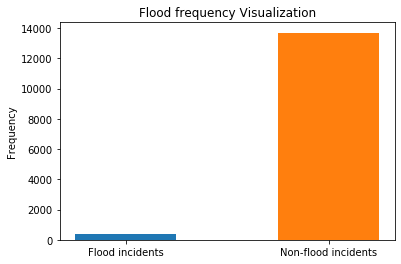

In [7]:
#Visualizing flood extent for 2015
x = train_set['target_2015'].value_counts()[1]
y = train_set['target_2015'].value_counts()[0]

fig, ax = plt.subplots()
ax.set_title("Flood frequency Visualization")
ax.bar('Flood incidents', x, width=0.5)
ax.bar('Non-flood incidents', y, width=0.5)
plt.ylabel('Frequency')

In [8]:
'''Computing mean precipitation for the train & test sets. '''

train_precip = train_set.columns[4:21]
train_set['mean_precip'] = np.mean(train_set[train_precip].values, axis=1)

'''Test set mean precipitation. '''
precip = test_set.columns[:17]
test_set['mean_precip'] = np.mean(test_set[precip].values, axis=1)

test_set.head(3)

,precip 2019-01-20 - 2019-01-27,precip 2019-01-27 - 2019-02-03,precip 2019-02-03 - 2019-02-10,precip 2019-02-10 - 2019-02-17,precip 2019-02-17 - 2019-02-24,precip 2019-02-24 - 2019-03-03,precip 2019-03-03 - 2019-03-10,precip 2019-03-10 - 2019-03-17,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,...,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,X,Y,elevation,LC_Type1_mode,Square_ID,mean_precip
0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,...,0.0,0.0,0.0,0.0,34.26,-15.91,887.764222,9,4e3c3896-14ce-11ea-bce5-f49634744a41,10.719605
1,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,...,0.0,0.0,0.0,0.0,34.26,-15.90,743.403912,9,4e3c3897-14ce-11ea-bce5-f49634744a41,10.719605
2,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,...,0.0,0.0,0.0,0.0,34.26,-15.89,565.728343,9,4e3c3898-14ce-11ea-bce5-f49634744a41,10.719605


In [11]:
'''Computing the rate of change in precipitation. '''
a = np.array(train_set[train_precip])
b = tf.Variable(np.mean(a, axis=1))
with tf.GradientTape() as tape:
    c = tf.square(b)
    dc_db = tape.gradient(c,b)
    print(dc_db)
    print(b)

tf.Tensor(
[29.71293888 29.71293888 29.71293888 ... 38.84168987 38.84168987
 38.84168987], shape=(16466,), dtype=float64)
<tf.Variable 'Variable:0' shape=(16466,) dtype=float64, numpy=
array([14.85646944, 14.85646944, 14.85646944, ..., 19.42084493,
       19.42084493, 19.42084493])>


## Modelling and Evaluation

In [12]:
# splitting dataset into train&test
target = train_set.pop('target_2015')

#Realigning the train&test sets
train_set, test_set = train_set.align(test_set, join='inner', axis=1)

In [13]:
train_set.head(3)

,X,Y,elevation,LC_Type1_mode,Square_ID,mean_precip
0,34.26,-15.91,887.764222,9,4e3c3896-14ce-11ea-bce5-f49634744a41,14.856469
1,34.26,-15.90,743.403912,9,4e3c3897-14ce-11ea-bce5-f49634744a41,14.856469
2,34.26,-15.89,565.728343,9,4e3c3898-14ce-11ea-bce5-f49634744a41,14.856469


In [14]:
Id = test_set['Square_ID']
train_set.drop(['Square_ID'], axis=1, inplace=True)
test_set.drop(['Square_ID'], axis=1, inplace=True)

In [15]:
# splitting the train_set to derive a validation set
X_train, X_val, y_train, y_val = train_test_split(train_set, target, test_size=0.2, random_state=42)

In [16]:
scorer = make_scorer(mean_absolute_error)
pipe = make_pipeline(RandomForestRegressor(random_state=42))

param_grid = {'randomforestregressor__n_estimators': [50, 100],
              'randomforestregressor__max_depth': [3],
              'randomforestregressor__min_samples_leaf': [1, 5],
              'randomforestregressor__n_jobs': [-1]
              }
gs = GridSearchCV(pipe, param_grid, cv=8, scoring=scorer)

gs.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
    

In [17]:
#evaluation
y_hat = gs.predict(X_val)
error = utils.rmse(y_val, y_hat)
error

0.15802508671782087

In [18]:
train_set.shape

(16466, 5)

### Predictions

In [19]:
predictions = gs.predict(test_set)
predictions.shape

(16466,)

(array([14013.,   109.,  1613.,    55.,    38.,    47.,    22.,   246.,
          130.,   193.]),
 array([0.0166343 , 0.1041559 , 0.19167749, 0.27919909, 0.36672068,
        0.45424228, 0.54176387, 0.62928546, 0.71680706, 0.80432865,
        0.89185025]),
 <a list of 10 Patch objects>)

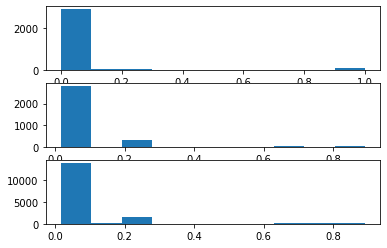

In [20]:
fig, ax = plt.subplots(nrows=3)
ax[0].hist(y_val, bins=10)
ax[1].hist(y_hat, bins=10)
ax[2].hist(predictions, bins=10)

In [21]:
submission['Square_ID'] = Id
submission['target_2019'] = predictions
submission.to_csv('submission.csv', index=False)

#LB:0.12156 (md3, rs42, no Scaler)

In [22]:
submission.min(), submission.max()

(Square_ID      4e3c3896-14ce-11ea-bce5-f49634744a41
 target_2019                               0.0166343
 dtype: object, Square_ID      4e6f5e01-14ce-11ea-bce5-f49634744a41
 target_2019                                 0.89185
 dtype: object)